/Users/akshatnagar/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


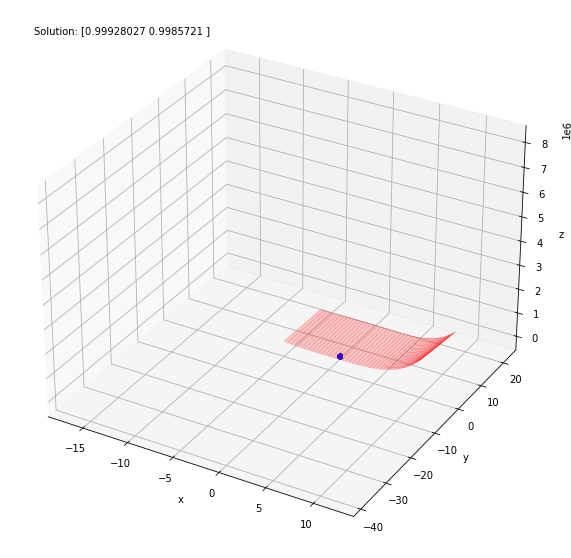

In [73]:
#https://www.sciencedirect.com/science/article/pii/S0925527310002938
#https://www.researchgate.net/publication/297245624_Particle_Swarm_Optimization_Algorithm_and_its_Codes_in_MATLAB
#https://www.mdpi.com/1999-4893/17/5/195


import matplotlib.pyplot as plt
from matplotlib import animation

class ParticleSwarmOptimization:
    def __init__(self, size, dimensions=2, w_max=0.9, w_min=0.4, iter_max=100):
        self.size = size
        self.dimensions = dimensions
        self.halton_engine = qmc.Halton(self.dimensions, scramble=False, seed=None)
        self.sobol_engine = qmc.Sobol(self.dimensions, scramble=False, seed=None)
        self.w_max = w_max
        self.w_min = w_min
        self.iter_max = iter_max
        self.iter = 0
        self.population = self.generate_population()
        self.velocity = self.initialize_velocity()
        self.pbest = self.population  # Initialize pbest as initial population
        self.gbest = self.find_gbest()

    def fitness(self, positions):
    # Rosenbrock function
        a = 1
        b = 100
        if positions.ndim > 1:
            x = positions[:, 0]
            y = positions[:, 1]
        else:
            x = positions[0]
            y = positions[1]
        return (a - x) ** 2 + b * (y - x ** 2) ** 2

    def run_optimization(self, convergence_threshold=1e-6):
    # Plotting preparation
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        x = np.linspace(-5, 10, 80)  # Adjust these limits as needed
        y = np.linspace(0, 15, 80)  # Adjust these limits as needed
        X, Y = np.meshgrid(x, y)
        Z = self.fitness(np.array([X.ravel(), Y.ravel()]).T).reshape(X.shape)
        ax.plot_wireframe(X, Y, Z, color='r', linewidth=0.2)

    # Animation image placeholder
        images = []

        previous_gbest_fitness = self.fitness(np.array([self.gbest]))

        while True:  # Run until convergence
            self.update_velocity_position()
            self.iter += 1
            self.gbest = self.find_gbest()
            current_gbest_fitness = self.fitness(np.array([self.gbest]))

        # Add plot for each generation
            image = ax.scatter3D(self.population[:, 0], self.population[:, 1], 
                                self.fitness(self.population), c='b')
            images.append([image])

        # Check for convergence
            if abs(current_gbest_fitness - previous_gbest_fitness) < convergence_threshold:
                break

            previous_gbest_fitness = current_gbest_fitness
        
        ax.text2D(0.05, 0.95, f"Solution: {self.gbest}", transform=ax.transAxes)
    # Generate the animation image and save
        animated_image = animation.ArtistAnimation(fig, images)
        animated_image.save('./pso_simple.gif', writer='pillow')

    def generate_population(self):
        # Generate the initial populations
        halton_population = self.halton_engine.random(n=self.size//2)
        sobol_population = self.sobol_engine.random(n=self.size//2)

        # Combine both populations
        initial_population = np.concatenate((halton_population, sobol_population))

        return initial_population

    def initialize_velocity(self):
        # Initialise Velocity
        halton_velocity = self.halton_engine.random(n=self.size//2)
        sobol_velocity = self.sobol_engine.random(n=self.size//2)
        init_velocity = np.concatenate((halton_velocity, sobol_velocity))

        return init_velocity

    def initialize_weight(self):
        # Initialize Inertia Weight
        return self.w_max

    def calculate_inertia_weight(self):
        # Calculate inertia weight
        w = self.w_max - ((self.w_max - self.w_min) / self.iter_max) * self.iter
        return max(w, self.w_min)  # Ensure w is not less than w_min

    def find_gbest(self):
        # Find global best position (gbest)
        fitness_values = self.fitness(self.population)
        gbest_index = np.argmin(fitness_values)
        return self.population[gbest_index]

    def optimize(self):
        while self.iter < self.iter_max:
            self.update_velocity_position()
            self.iter += 1
            self.gbest = self.find_gbest()

    def update_velocity_position(self):
        # Update velocity and position for each particle
        c1 = c2 = 2  # Learning factors
        r1 = np.random.rand(self.size, self.dimensions)
        r2 = np.random.rand(self.size, self.dimensions)

        # Calculate new inertia weight
        w = self.calculate_inertia_weight()

        # Update velocity
        self.velocity = w * self.velocity + c1 * r1 * (self.pbest - self.population) + \
                        c2 * r2 * (self.gbest - self.population)

        # Update position
        self.population += self.velocity




pso = ParticleSwarmOptimization(size=100, dimensions=2)
pso.run_optimization()

In [12]:
import sys
sys.path.append('/path/to/src')

In [2]:
from enum import Enum
from typing import Any, Self
import numpy as np
from pydantic import BaseModel
from src.production_orders import Data, Product, BillOfMaterial
import networkx as nx
import matplotlib.pyplot as plt

DAY_MINUTES = 24 * 60


class Job(BaseModel):
    available_machines: dict[int, int]
    dependencies: list[int]
    production_order_nr: str
    station_settings: dict[str, Any] = dict()
    amount: int = 1
    days_till_delivery: int = 0


class Machine(BaseModel):
    name: str
    machine_id: int
    start_time: int = 0
    end_time: int
    allow_preemption: bool = False
    max_units_per_run: int = 1
    minutes_per_run: float


class ScheduleError(Exception): ...


schedule_type = dict[int, list[tuple[int, int, int]]]


class JobShopProblem:
    LOW_TARDINESS = None
    LOW_TOTAL_SETUP_TIME = None
    LOW_MAKESPAN = None

    def __init__(self, data: Data, jobs: list[Job], machines: list[Machine]) -> None:
        self.data: Data = data
        self.jobs: list[Job] = jobs
        self.machines: list[Machine] = machines
        self.setup_times: np.ndarray = np.zeros((len(jobs), len(jobs)))
        self.graph = self._build_graph()

    def _build_graph(self) -> nx.DiGraph:
        graph = nx.DiGraph()
        graph.add_nodes_from([-1, -2] + [x for x in range(len(self.jobs))])
        edges = list()
        for job_idx, job in enumerate(self.jobs):
            if len(job.dependencies) == 0:
                edges.append((-1, job_idx))
                continue
            for dep in job.dependencies:
                edges.append((dep, job_idx))
        graph.add_edges_from(edges)
        for node, outdegree in graph.out_degree(graph.nodes()):
            if outdegree == 0 and node >= 0:
                graph.add_edge(node, -2)
        return graph

    def visualize_schedule(
        self,
        schedule: dict[int, list[tuple[int, int, int]]],
        save_path: str | None = None,
    ):
        """Visualizes a schedule."""
        fig, ax = plt.subplots(figsize=(13, 7))
        cmap = plt.get_cmap("tab20")
        for i, (machine, sch) in enumerate(schedule.items()):
            for idx, task in enumerate(sch):
                job_id, start_time, end_time = task
                if job_id == -1:
                    continue
                setup_time = self.setup_times[sch[idx - 1][0], job_id]
                # Check if we have a preemption job
                plot_times = [(start_time, end_time, setup_time)]
                if (
                    end_time - start_time - setup_time
                    > self.jobs[job_id].available_machines[machine]
                ):
                    plot_times = [
                        (
                            start_time,
                            self.machines[machine].end_time
                            + 24 * 60 * (start_time // (24 * 60)),
                            setup_time,
                        ),
                        (
                            self.machines[machine].start_time
                            + 24 * 60 * (end_time // (24 * 60)),
                            end_time,
                            0,
                        ),
                    ]
                for start_time, end_time, setup_time in plot_times:
                    ax.plot(
                        [start_time + setup_time, end_time],
                        [i + 1, i + 1],
                        linewidth=50,
                        label=self.jobs[job_id].production_order_nr,
                        solid_capstyle="butt",
                        color=cmap(
                            int(self.jobs[job_id].production_order_nr.removeprefix("P"))
                        ),
                    )
                    ax.plot(
                        [start_time, start_time + setup_time],
                        [i + 1, i + 1],
                        linewidth=50,
                        solid_capstyle="butt",
                        color=cmap(
                            int(self.jobs[job_id].production_order_nr.removeprefix("P"))
                        ),
                        alpha=0.5,
                    )
                    color = "black"
                    if end_time - self.jobs[job_id].days_till_delivery * 24 * 60 > 0:
                        color = "red"

                    ax.text(
                        (start_time + end_time) / 2,
                        i + 1,
                        self.jobs[job_id].production_order_nr,  # + f" ({job_id})",
                        va="center",
                        ha="right",
                        fontsize=11,
                        color=color,
                    )
        flat_schedule = list()
        for val in schedule.values():
            flat_schedule.extend(val)
        max_time = max([t[2] for t in flat_schedule])

        day_markers = np.arange(0, max_time, 24 * 60)
        day_labels = [f"{d//24//60}" for d in day_markers]

        plt.xticks(ticks=np.concatenate([day_markers]), labels=day_labels)
        plt.yticks(
            ticks=np.arange(1, len(schedule) + 1),
            labels=[f"Machine {m}" for m in schedule.keys()],
        )
        plt.xlabel("Days")
        plt.ylabel("Machine")
        plt.tight_layout()

        for machine in self.machines:
            x_lines_start = np.arange(machine.start_time, max_time, 24 * 60)
            plt.vlines(
                x_lines_start,
                machine.machine_id + 0.5,
                machine.machine_id + 1.5,
                linestyles="dashed",
                color="green",
            )
            x_lines_end = np.arange(machine.end_time, max_time, 24 * 60)
            plt.vlines(
                x_lines_end,
                machine.machine_id + 0.5,
                machine.machine_id + 1.5,
                linestyles="dashed",
                color="red",
            )

        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()

    @classmethod
    def from_data(cls, data: Data) -> Self:
        """Generate a JobShopProblem from the data provided according to the excel sheet.

        Args:
            data (Data): The data that is parsed from the excel sheet.

        Returns:
            Self: The JobShopProblem object.
        """
        sub_jobs: list[Job] = list()
        machines: list[Machine] = [
            Machine(
                name=m.name,
                machine_id=idx,
                start_time=m.starts_at.hour * 60 + m.starts_at.minute,
                end_time=m.stops_at.hour * 60 + m.stops_at.minute,
                allow_preemption=(m.name.lower().startswith("bottling")),
                max_units_per_run=m.max_units_per_run,
                minutes_per_run=m.minutes_per_run,
            )
            for idx, m in enumerate(data.workstations)
        ]
        for order in data.production_orders:
            # We collect all the products we need to produce
            # 1. We get the final product from the products table
            # 2. We look in the bill of materials to see if that product has any sub products that are needed
            # 3. If it has, we add the sub product from the products table and repeat step 2.
            products = list()
            curent_product = order.product_id
            while curent_product is not None:
                product = data.products[curent_product]
                bill_of_materials = data.bill_of_materials.get(curent_product, None)
                products.append((product, bill_of_materials))
                if bill_of_materials:
                    curent_product = bill_of_materials.component_id
                else:
                    curent_product = None
            # We reverse the products list, because the products have to be produced in sequential order
            products: list[tuple[Product, BillOfMaterial | None]] = products[::-1]
            # We split the job into batches of the same product
            product_info = list()
            # NOTE: amount is different from the amount in the job, since we calcualte the
            # amount based on what unit the machine can process
            for idx, (prod, _) in enumerate(products):
                prod_info = dict()
                if idx + 1 < len(products):
                    bom = products[idx + 1][1]
                else:
                    bom = None
                amount = order.amount * bom.component_quantity if bom else order.amount
                prod_info["amount"] = amount
                # HACK: we are shortening the name by 1 since it says bottle and not bottling, which the machine name is
                prod_info["machines"] = [
                    m.machine_id
                    for m in machines
                    if m.name.lower().startswith(prod.workstation_type[:-1])
                ]
                # HACK: the batch sizes are not calculated per machine, so if two machines
                # that process the same job has different ones, we will take the one that has
                # the lowest capacity to calculate the batch size
                min_max_units_per_run = min(
                    [machines[m].max_units_per_run for m in prod_info["machines"]]
                )
                prod_info["batches"] = max(int(amount // min_max_units_per_run), 1)
                prod_info["batches_amount"] = min_max_units_per_run
                remainder = int(amount % min_max_units_per_run)
                prod_info["batches_remainder"] = (
                    remainder if remainder > 0 else min_max_units_per_run
                )
                product_info.append(prod_info)
            # We calculate the correct batch size, or in other words the job that has
            # the smallest batch amount size, since that will be the bottle neck.
            # However, we ignore if the jobs can be run independently, since we will just make that into
            # one batch
            batch_info = min(
                product_info,
                key=lambda x: x["batches_amount"] if x["batches_amount"] > 1 else 10e4,
            )
            for i in range(batch_info["batches"]):
                for idx, prod in enumerate(product_info):
                    dependencies = list()
                    if idx > 0:
                        dependencies.append(len(sub_jobs) - 1)

                    amount = prod["amount"] // batch_info["batches"]
                    if i == batch_info["batches"] - 1:
                        amount = prod["amount"] % batch_info["batches"]
                        if amount == 0:
                            amount = prod["amount"] // batch_info["batches"]

                    sub_jobs.append(
                        Job(
                            available_machines={
                                m: data.workstations[m].minutes_per_run * amount
                                if data.workstations[m].max_units_per_run == 1
                                else data.workstations[m].minutes_per_run
                                for m in prod["machines"]
                            },
                            dependencies=dependencies,
                            production_order_nr=order.production_order_nr,
                            station_settings={
                                "taste": products[idx][0].setting_taste,
                                "bottle_size": products[idx][0].setting_bottle_size,
                            },
                            amount=amount,
                            days_till_delivery=order.days_till_delivery,
                        )
                    )
        jssp = cls(data=data, jobs=sub_jobs, machines=machines)

        # Set setup-times
        for j1_idx, j1 in enumerate(jssp.jobs):
            for j2_idx, j2 in enumerate(jssp.jobs):
                if j1 == j2 or j1.production_order_nr == j2.production_order_nr:
                    continue
                if j1.station_settings["taste"] != j2.station_settings["taste"]:
                    jssp.setup_times[j1_idx, j2_idx] += jssp.data.workstations[
                        list(j1.available_machines.keys())[0]
                    ].minutes_changeover_time_taste

                if (
                    j1.station_settings["bottle_size"]
                    != j2.station_settings["bottle_size"]
                ):
                    jssp.setup_times[j1_idx, j2_idx] += jssp.data.workstations[
                        list(j1.available_machines.keys())[0]
                    ].minutes_changeover_time_bottle_size

        return jssp

    def make_schedule(
        self, job_order: list[int], machine_assignment: list[int]
    ) -> schedule_type:
        """Create a schedule based on a give job order and machine assignment.

        Note that the job_order is relative, and machine_assignment is absolute. That means that
        the machine_assignment have at index i the machine assignment for job i. While the job_order
        at index i is the job that should be done at position i in relation to the other jobs in the list.

        Args:
            job_order (list[int]): the order of the jobs that should be done
            machine_assignment (list[int]): what machine job i should be done on

        Raises:
            ScheduleError: raised if the job order or machine assignment is incorrect

        Returns:
            dict[int, list[tuple[int, int, int]]]: the schedule for each machine with the job id, start time and end time
                relative to midnight of day 0.
        """
        # Contains the schedule for each machine
        schedule: dict[int, list[tuple[int, int, int]]] = {
            m.machine_id: [(-1, 0, m.start_time)] for m in self.machines
        }

        # Contains the machine, start time and end time for each job
        job_schedule: dict[int, tuple[int, int, int]] = dict()

        for task_idx in job_order:
            task: Job = self.jobs[task_idx]
            machine_idx = machine_assignment[task_idx]
            if machine_idx not in task.available_machines:
                raise ScheduleError(
                    f"Machine {machine_idx} not available for task {task_idx}"
                )
            machine = self.machines[machine_idx]

            relevant_task: list[tuple[int, int, int]] = list()

            # Get the last job on the same machine
            latest_job_on_same_machine = schedule[machine_idx][-1]
            relevant_task.append(latest_job_on_same_machine)

            # Check for dependencies
            if len(task.dependencies) > 0:
                for dep in task.dependencies:
                    if dep_task := job_schedule.get(dep, None):
                        relevant_task.append(dep_task)
                    else:
                        raise ScheduleError(
                            f"Dependency {dep} not scheduled before {task_idx}"
                        )

            # Get the start time of the task
            start_time = max([task[2] for task in relevant_task])

            task_duration: int = int(
                task.available_machines[machine_idx]
                + self.setup_times[latest_job_on_same_machine[0], task_idx]
            )
            # If task is schedule before the machine starts, we move it to the start time
            if start_time % DAY_MINUTES < machine.start_time:
                start_time = (
                    machine.start_time + (start_time // DAY_MINUTES) * DAY_MINUTES
                )

            # If the task ends after the machine stops, we move it to the next day, unless we allow preemption.
            # If we allow preemption we will just continue with the work the next day
            if start_time % DAY_MINUTES + task_duration > machine.end_time:
                # If we allow for preemption we will just add to the duration the time inbetween start and end time
                if machine.allow_preemption:
                    task_duration += DAY_MINUTES - machine.end_time + machine.start_time
                else:
                    start_time = (
                        machine.start_time
                        + (start_time // DAY_MINUTES + 1) * DAY_MINUTES
                    )

            end_time = start_time + task_duration
            schedule[machine_idx].append((task_idx, start_time, end_time))
            job_schedule[task_idx] = (machine_idx, start_time, end_time)

        return schedule

    def makespan(self, schedule: schedule_type) -> int:
        """Calculate the makespan of the schedule.

        Args:
            schedule (schedule): the schedule that should be evaluated

        Returns:
            int: the makespan of the schedule
        """
        return max([task[2] for machine in schedule.values() for task in machine])

    def tardiness(self, schedule: schedule_type) -> int:
        """Calculate the tardiness of the schedule. The tardiness is the number of sub jobs that are late.

        As soon as just 1 sub job is late the whole order is late, and should be penalized.

        Args:
            schedule (schedule): the schedule that should be evaluated

        Returns:
            int: the tardiness of the schedule
        """
        production_order_lateness = {
            order.production_order_nr: [] for order in self.data.production_orders
        }
        for machine in schedule.values():
            for task in machine:
                production_order_lateness[
                    self.jobs[task[0]].production_order_nr
                ].append(
                    max(
                        task[2] - self.jobs[task[0]].days_till_delivery * DAY_MINUTES, 0
                    )
                )

        tardiness = 0
        for lateness in production_order_lateness.values():
            if any([l > 0 for l in lateness]):
                tardiness += np.average(lateness) * len(lateness)
        return int(tardiness)

    def total_setup_time(self, schedule: schedule_type) -> int:
        """Calculate the total setup time of the schedule.

        Args:
            schedule (schedule): the schedule that should be evaluated

        Returns:
            int: the total setup time of the schedule
        """
        setup_time = 0
        for machine in schedule.values():
            for idx, task in enumerate(machine):
                if idx > 0:
                    setup_time += self.setup_times[machine[idx - 1][0], task[0]]
        return setup_time

    def custom_objective(self, schedule: schedule_type) -> float:
        tardiness = self.tardiness(schedule)
        total_setup_time = self.total_setup_time(schedule)
        makespan = self.makespan(schedule)
        if self.LOW_TARDINESS is None:
            self.LOW_TARDINESS = 1600.0
        if self.LOW_TOTAL_SETUP_TIME is None:
            self.LOW_TOTAL_SETUP_TIME = 10.0
        if self.LOW_MAKESPAN is None:
            self.LOW_MAKESPAN = 3600.0

        return (
            (tardiness - self.LOW_TARDINESS) / self.LOW_TARDINESS
            + (total_setup_time - self.LOW_TOTAL_SETUP_TIME) / self.LOW_TOTAL_SETUP_TIME
            + (makespan - self.LOW_MAKESPAN) / self.LOW_MAKESPAN
        )


class ObjectiveFunction(Enum):
    CUSTOM_OBJECTIVE = 0
    MAKESPAN = 1
    TARDINESS = 2
    TOTAL_SETUP_TIME = 3

ModuleNotFoundError: No module named 'src'

In [20]:
import os
print(os.getcwd())

/Users/akshatnagar/Documents/GitHub/bachelors-thesis/AKSHAT/PSO


In [21]:
import sys
sys.path.append('/path/to/src')

In [3]:
pip install src

  Using cached src-0.0.7.zip (6.3 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for src (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [68 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib
      creating build/lib/src
      copying src/__init__.py -> build/lib/src
      running egg_info
      writing src.egg-info/PKG-INFO
      writing dependency_links to src.egg-info/dependency_links.txt
      writing requirements to src.egg-info/requires.txt
      writing top-level names to src.egg-info/top_level.txt
      reading manifest file 'src.egg-info/SOURCES.txt'
      reading manifest template 'MANIFEST.in'
      adding license file 'LICENSE.rst'
      writing manifest file 'src.egg-info/SOURCES.txt'